In [95]:
import geopandas as gpd
import momepy
import pandana
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx

from matplotlib_scalebar.scalebar import ScaleBar
from geemap import cartoee

cartopy is not installed. Please see https://scitools.org.uk/cartopy/docs/latest/installing.html#installing for instructions on how to install cartopy.

The easiest way to install cartopy is using conda: conda install -c conda-forge cartopy


In [93]:
local_crs = 2154

In [80]:
# load data
streets = gpd.read_parquet('./data/streets.parquet')
hexagons = gpd.read_parquet('./data/hexagons.parquet')
centroids = gpd.read_parquet('./data/centroids.parquet')

In [81]:
## generate pandana network
# nodes and edges for walk network
nodes_walk, edges_walk = momepy.nx_to_gdf( # convert network to gdf
    momepy.gdf_to_nx( # convert to nx graph
        streets.explode() # remove multipart rows
    )
)
nodes_walk = nodes_walk.set_index('nodeID') # set index

# generate walk pandana network
streets_pdna = pandana.Network( 
    nodes_walk.geometry.x,
    nodes_walk.geometry.y,
    edges_walk['node_start'], # set origins
    edges_walk['node_end'], # set destinations
    edges_walk[['mm_len']] # set edge length
)

C:\Users\b9066009\AppData\Local\Temp\ipykernel_6004\1189012362.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  streets.explode() # remove multipart rows


In [82]:
# attach pois to the network
streets_pdna.set_pois( # snap pois to network
    category = 'pois', # set name of the new layer snapped on the network
    maxdist = 1200, # set maximum distance
    maxitems = 700, # set maximum number of pois to look for
    x_col = centroids.geometry.x,
    y_col = centroids.geometry.y
)
results = streets_pdna.nearest_pois( # calculate distances to pois
    distance = 1200, # maximum distance
    category = 'pois', # layer where we want to look for
    num_pois = 700, # max number of pois to look for
    include_poi_ids = True # include pois ids
)

In [83]:
# store results separately as distances and poiIDs

# separate distances from poi ids
distances = results.iloc[:,:round(len(results.columns)/2,)] # create df with distances
pois_ids = results.iloc[:,round(len(results.columns)/2,):] # create df with pois ids

# convert wide matrices to long
distances_long = pd.melt(distances.reset_index(), id_vars='nodeID',value_name='distance') # make matrix long
pois_ids_long = pd.melt(pois_ids.reset_index(), id_vars='nodeID',value_name='centroidID') # make matrix long

# create an od long df containing nodeID, distance, and poiID
od = distances_long
od['centroidID'] = pois_ids_long['centroidID'] # set a column with pois ids (as they are indexed, they are already in the right order)

# format od matrix and drop NAs
od = od[['nodeID','centroidID','distance']] # clean columns
od = od.dropna() # drop NAs

In [84]:
# calculate nearest node to each centroid
centroids['nodeID'] = streets_pdna.get_node_ids(centroids.geometry.x, centroids.geometry.y)
centroids = centroids.reset_index()

In [85]:
od = pd.merge(od, centroids)

In [86]:
od

,nodeID,centroidID,distance,index,geometry
0,0,8b186086dc54fff,0.00000,8b186086dc54fff,POINT (452322.798 6904890.418)
1,0,8b186086dc54fff,0.00000,8b186086dc56fff,POINT (452276.330 6904888.053)
2,0,8b186086dc54fff,0.00000,8b186086dc0dfff,POINT (452313.148 6904975.629)
3,0,8b186086dc54fff,0.00000,8b186086dc73fff,POINT (452369.266 6904892.783)
4,0,8b186086dc54fff,0.00000,8b186086dc55fff,POINT (452350.857 6904848.995)
...,...,...,...,...,...
8580134,10695,8b1865498071fff,1195.33606,8b186549d49efff,POINT (457136.958 6902607.717)
8580135,10695,8b1865498073fff,1195.33606,8b186549886dfff,POINT (457090.515 6902605.347)
8580136,10695,8b1865498073fff,1195.33606,8b186549d49efff,POINT (457136.958 6902607.717)
8580137,10695,8b1865498055fff,1195.33606,8b186549886dfff,POINT (457090.515 6902605.347)


In [88]:
access = od.groupby(['index']).size().reset_index()
access = access.rename(columns= {0:'access'})

In [89]:
test = pd.merge(centroids, access)
test = test.rename(columns= {0:'access'})

In [90]:
access_score = pd.merge(hexagons, access, left_on='hex_id', right_on='index')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AttributeError: 'Legend' object has no attribute 'axis'

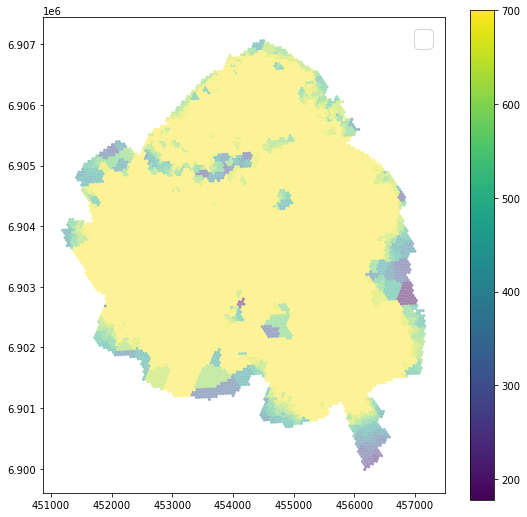

In [104]:
f, ax = plt.subplots(1, figsize=(9,9))
ax = access_score.to_crs(local_crs).plot(ax = ax, 
                                         column = 'access',
                                         legend = True,
                                         alpha = 0.5)
cx.add_basemap(ax,
               crs=local_crs,
               source = cx.providers.OpenStreetMap.France)

ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    location=(4),
                    height_fraction=0.01
                    )
ax.add_artist(scalebar)

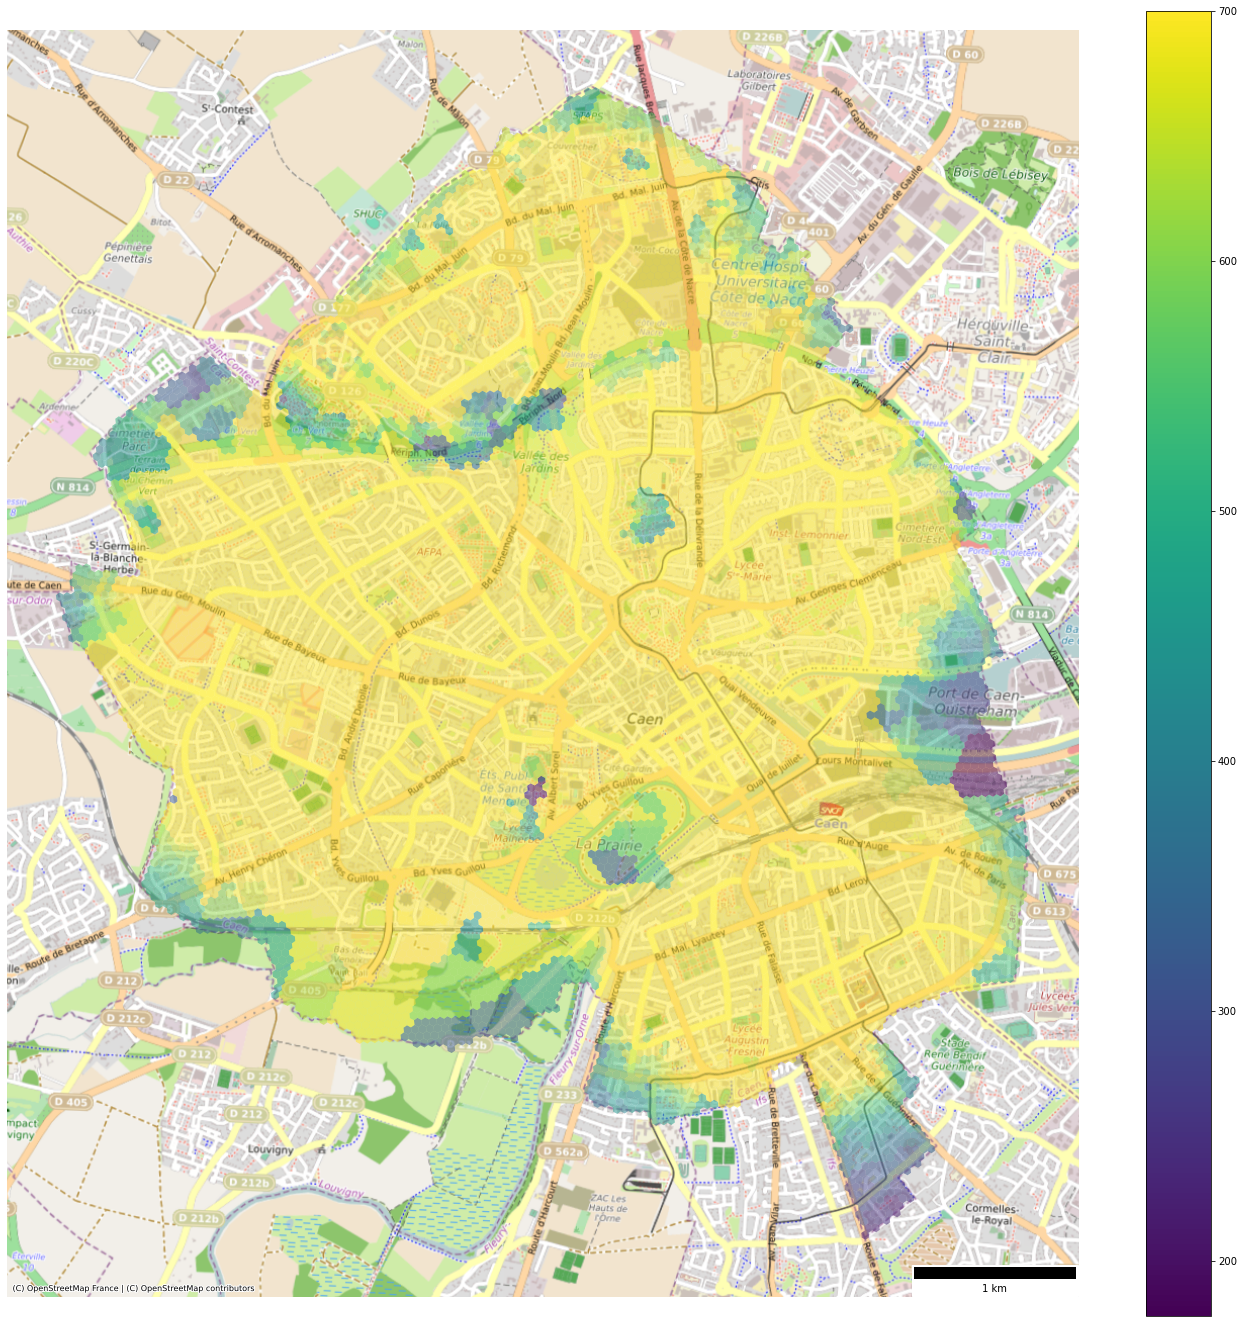

In [103]:
# study area map
f, ax = plt.subplots(1, figsize=(24,24))
ax = access_score.to_crs(local_crs).plot(ax = ax, 
                                         column = 'access',
                                         legend = True,
                                         alpha = 0.5)
cx.add_basemap(ax,
               crs=local_crs,
               source = cx.providers.OpenStreetMap.France)

ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    location=(4),
                    height_fraction=0.01
                    )
ax.add_artist(scalebar)

plt.savefig('./figures/access_score.png', bbox_inches='tight')